In [72]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import glob
from PIL import Image

In [73]:
plt.rcParams['figure.figsize'] = [12, 8]

In [74]:
# path: path to folder of images
def get_formatted_images(path, cnt):
    image_list = []
    for idx, file_name in enumerate(glob.glob(path + '/*.png')):
        if idx >= cnt:
            break

        img = np.array(Image.open(file_name))

        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
        #elif len(img.shape) == 2:
        #    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        h, w, d = img.shape
        min_dim = min(h, w)
        img = img[0:min_dim, 0:min_dim]

        image_list.append(img)
    return image_list

def get_labels(images, label):
    labels = [label] * len(images)
    return labels

(25, 100, 100, 3)


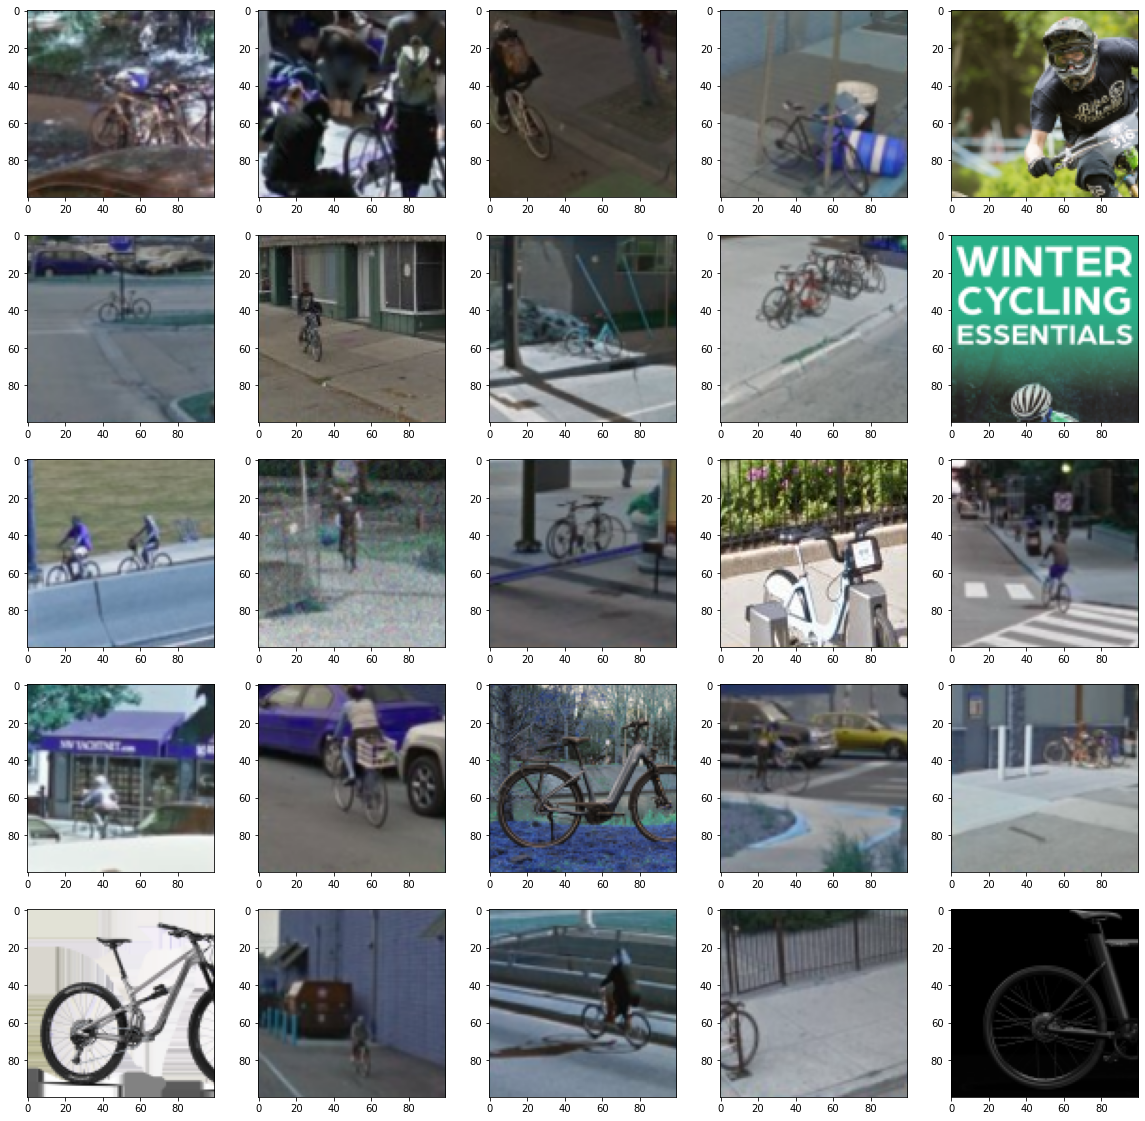

In [75]:
# from helper import get_formatted_images, get_labels

picture = 'Bicycle'

#path = 'G:\\My Drive\\School\\6. Spring 2022\\EE379K - COMPUTER VISION\\CAPTCHA Solver\\archive\\Recaptcha Dataset\\Bicycle'
path = '/Users/andrewwhitaker/Downloads/Recaptcha Dataset/' + picture

num_imgs = 100
plt.figure(figsize=(20, 20))

# bicycle:
images = get_formatted_images(path, cnt=num_imgs)
labels = get_labels(images, picture)
test_images = []

for i, img in enumerate(images[:25]):
    dim = (100, 100)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    test_images.append(resized)
    plt.subplot(5, 5, i+1)
    plt.imshow(resized, cmap='gray')

test_images = np.array(test_images)
print(test_images.shape)

In [77]:
batch_size = 32
img_height = 100
img_width = 100

#data_dir = 'G:\\My Drive\\School\\6. Spring 2022\\EE379K - COMPUTER VISION\\CAPTCHA Solver\\archive\\Recaptcha Dataset'
data_dir = '/Users/andrewwhitaker/Downloads/Recaptcha Dataset/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 238399 files belonging to 17 classes.
Using 190720 files for training.
Found 238399 files belonging to 17 classes.
Using 47679 files for validation.


In [78]:
len(train_ds.class_names)

17

In [92]:
with tf.device("/cpu:0"):
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(100,100,3)),
    tf.keras.layers.RandomRotation(0.2),
  ])

In [93]:
scale_pixels = tf.keras.layers.Rescaling(1/127.5, offset=-1)

In [94]:
# use the google mobilev2 model without including the last dense layer
transfer_model = tf.keras.applications.MobileNetV2(input_shape=(100,100,3), include_top=False, weights='imagenet')
transfer_model.trainable = False

In [95]:
im_batch, labels = next(iter(train_ds))
features_128 = transfer_model(im_batch)

In [96]:
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
features_128_avg = pooling_layer(features_128)

In [97]:
prediction_layer = tf.keras.layers.Dense(17)
predictions = prediction_layer(features_128_avg)

In [98]:
with tf.device("/cpu:0"):
    input = tf.keras.Input(shape=(100, 100, 3))
    x = data_augmentation(input)
    x = scale_pixels(x)
    x = transfer_model(x, training=False)
    x = pooling_layer(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = prediction_layer(x)
    model = tf.keras.Model(input, output)

In [99]:
with tf.device("/cpu:0"):
    model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [34]:
#loss, accuracy = model.evaluate(val_ds)

1490/1490 [==============================] - 68s 45ms/step - loss: 2.7703 - accuracy: 0.2151


In [100]:
with tf.device("/cpu:0"):
    history = model.fit(train_ds, epochs=10,validation_data=val_ds)

Epoch 1/10
5960/5960 [==============================] - 665s 111ms/step - loss: 0.5067 - accuracy: 0.8621 - val_loss: 0.3460 - val_accuracy: 0.8910
Epoch 2/10
5960/5960 [==============================] - 732s 123ms/step - loss: 0.4761 - accuracy: 0.8699 - val_loss: 0.3388 - val_accuracy: 0.8999
Epoch 3/10
5960/5960 [==============================] - 1823s 306ms/step - loss: 0.4780 - accuracy: 0.8702 - val_loss: 0.3346 - val_accuracy: 0.8973
Epoch 4/10
5960/5960 [==============================] - 679s 114ms/step - loss: 0.4820 - accuracy: 0.8692 - val_loss: 0.3900 - val_accuracy: 0.8805
Epoch 5/10
5960/5960 [==============================] - 778s 130ms/step - loss: 0.4816 - accuracy: 0.8695 - val_loss: 0.3481 - val_accuracy: 0.8920
Epoch 6/10
5960/5960 [==============================] - 927s 155ms/step - loss: 0.4835 - accuracy: 0.8700 - val_loss: 0.3389 - val_accuracy: 0.8993
Epoch 7/10
5960/5960 [==============================] - 795s 133ms/step - loss: 0.4811 - accuracy: 0.8711 - val

In [ ]:
transfer_model.trainable = True
for layer in transfer_model.layers[:80]:
    layer.trainable = False
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])